In [1]:
import yfinance as yahoo
import pandas as pd
import numpy as np
import scipy.optimize as sco
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
consume = ['KO','ABEV','MCD','ARCO','WMT','PG','NKE','PEP','COST','MO', 'TGT']

In [3]:
df = yahoo.download(consume,period="1y",interval="60m")['Adj Close'].fillna(method='ffill')
df = df.fillna(method='ffill')
start, end = df.iloc[0,:], df.iloc[-1,:]
renta = (end / start)
renta = renta.sort_values(axis=0,ascending=False)
renta

[*********************100%***********************]  11 of 11 completed


TGT     1.651028
NKE     1.321783
COST    1.242357
WMT     1.197525
PG      1.154800
PEP     1.056174
MCD     0.952261
MO      0.927419
KO      0.903075
ARCO    0.689265
ABEV    0.524625
dtype: float64

In [4]:
df

,ABEV,ARCO,COST,KO,MCD,MO,NKE,PEP,PG,TGT,WMT
Datetime,,,,,,,,,,,
2019-08-15 09:30:00-04:00,4.670,7.050987,270.510010,53.650002,217.429993,45.880001,80.519997,130.130096,116.989998,82.699997,110.720001
2019-08-15 10:30:00-04:00,4.673,7.120066,270.859985,53.689999,217.455002,45.970001,80.440002,130.100006,117.370003,83.010002,111.750000
2019-08-15 11:30:00-04:00,4.670,7.203948,270.899994,53.849998,218.089996,45.889999,79.915001,130.419998,117.760002,82.680000,110.839996
2019-08-15 12:30:00-04:00,4.650,7.189737,270.510010,53.815300,217.509995,45.625000,79.830002,130.869995,117.639999,82.570000,110.894997
2019-08-15 13:30:00-04:00,4.635,7.185394,270.867096,53.810001,217.440002,45.564999,79.580002,130.910004,117.581001,82.550003,111.269997
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-14 11:30:00-04:00,2.485,4.810000,337.350006,48.500000,206.660004,42.575001,106.495003,137.854996,134.910004,135.709702,132.320099
2020-08-14 12:30:00-04:00,2.450,4.820000,337.079987,48.438801,207.050003,42.575001,106.419998,137.809998,134.889999,136.395004,132.604996
2020-08-14 13:30:00-04:00,2.460,4.827500,336.899994,48.474998,207.179993,42.630001,106.550003,137.690002,135.149994,136.929993,132.785004


In [5]:
noa = len(df.columns) #number of assets
weights = np.random.random(noa)
weights /= np.sum(weights)
observations = len(df.index)
alpha = 0.05
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()

In [6]:
def calc_portfolio_VaR(weights, mean_returns, cov, alpha, observations):
    portfolio_return = np.sum(mean_returns * weights) * observations
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(observations)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_var

def min_VaR(mean_returns, cov, alpha, observations):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, alpha, observations)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (-0.3,0.3)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_VaR, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result


In [7]:
min_port_VaR = min_VaR(mean_returns, cov, alpha, observations)

minimal_VaR = pd.DataFrame(index=df.columns)
minimal_VaR['weigths'] = pd.DataFrame([round(x,3) for x in min_port_VaR['x']],index=df.columns)
minimal_VaR.weigths.sort_values(axis=0,ascending=False)

WMT     0.299
COST    0.298
PG      0.285
TGT     0.284
NKE     0.267
PEP     0.164
MO      0.029
MCD    -0.009
KO     -0.029
ABEV   -0.289
ARCO   -0.300
Name: weigths, dtype: float64

In [8]:
portfolio = (df * minimal_VaR.weigths).T.sum()

retorno = portfolio.pct_change().cumsum()

benchmark = df.T.mean() # build an equally weigthed portfolio to use as benchmark

assets_return = df.pct_change().cumsum() # spectrum of the assets returns


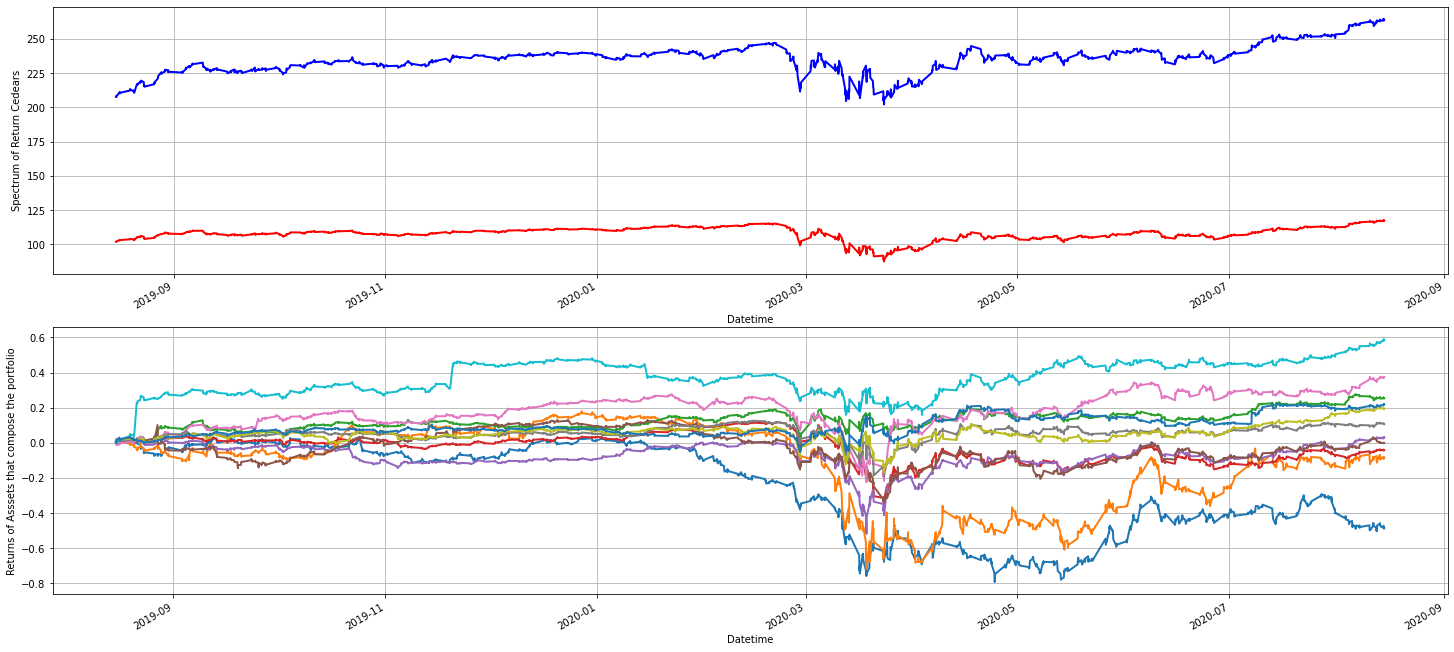

In [9]:
fig = plt.figure(figsize=(25,12))
ax1 = fig.add_subplot(211, ylabel='Spectrum of Return Cedears')
portfolio.plot(ax=ax1, color='b', lw=2.)
benchmark.plot(ax=ax1, color='r', lw=2.)
ax1.grid()
ax2 = fig.add_subplot(212, ylabel='Returns of Asssets that compose the portfolio')
assets_return.plot(ax=ax2, lw=2., legend=False)
ax2.grid()
plt.show()

In [10]:
portfolio, benchmark

(Datetime
 2019-08-15 09:30:00-04:00    207.739261
 2019-08-15 10:30:00-04:00    208.301207
 2019-08-15 11:30:00-04:00    207.933799
 2019-08-15 12:30:00-04:00    207.828276
 2019-08-15 13:30:00-04:00    207.968812
                                 ...    
 2020-08-14 11:30:00-04:00    263.934373
 2020-08-14 12:30:00-04:00    264.105990
 2020-08-14 13:30:00-04:00    264.341477
 2020-08-14 14:30:00-04:00    263.463699
 2020-08-14 15:30:00-04:00    263.830501
 Length: 1765, dtype: float64,
 Datetime
 2019-08-15 09:30:00-04:00    101.841007
 2019-08-15 10:30:00-04:00    102.039824
 2019-08-15 11:30:00-04:00    102.019903
 2019-08-15 12:30:00-04:00    101.918639
 2019-08-15 13:30:00-04:00    101.944864
                                 ...    
 2020-08-14 11:30:00-04:00    117.242710
 2020-08-14 12:30:00-04:00    117.321253
 2020-08-14 13:30:00-04:00    117.416135
 2020-08-14 14:30:00-04:00    117.037891
 2020-08-14 15:30:00-04:00    117.230001
 Length: 1765, dtype: float64)

In [11]:
minimal_VaR = pd.DataFrame(index=df.columns)
minimal_VaR['weigths'] = pd.DataFrame([round(x,2) for x in min_port_VaR['x']],index=df.columns)
minimal_VaR.weigths.sort_values(axis=0,ascending=False)

WMT     0.30
COST    0.30
TGT     0.28
PG      0.28
NKE     0.27
PEP     0.16
MO      0.03
MCD    -0.01
KO     -0.03
ABEV   -0.29
ARCO   -0.30
Name: weigths, dtype: float64

In [12]:
portfolio = (df * minimal_VaR.weigths).T.sum()
portfolio

Datetime
2019-08-15 09:30:00-04:00    206.966420
2019-08-15 10:30:00-04:00    207.526859
2019-08-15 11:30:00-04:00    207.154263
2019-08-15 12:30:00-04:00    207.047371
2019-08-15 13:30:00-04:00    207.188492
                                ...    
2020-08-14 11:30:00-04:00    263.076999
2020-08-14 12:30:00-04:00    263.245381
2020-08-14 13:30:00-04:00    263.477997
2020-08-14 14:30:00-04:00    262.604091
2020-08-14 15:30:00-04:00    262.967701
Length: 1765, dtype: float64

In [13]:
data = df

# Calculate the returns of instruments, statistics & correlation
returns = (data - data.shift(1))/ data.shift(1)# get the returns for every serie

statistics = returns.describe().T

statistics['mad'] = returns.mad()

statistics['skew'] = returns.skew()

statistics['kurtosis'] = returns.kurtosis()

statistics = statistics.T

correlation = returns.corr() # correlation

covariance = returns.cov()  # covariance

# Calculate the deltas of the instruments as the weights assigned multiplied by their correlations (elasticity)
instruments = pd.DataFrame(index= data.columns)
instruments['weigths'] = 1/len(instruments.index) # secure allocation is equal 1
instruments['deltas'] = (instruments.weigths * correlation).sum() # deltas as elasticity of the assets
instruments['Stdev'] = returns.std()
instruments['stress'] = (instruments.deltas * instruments.Stdev) * 3 # stress applied at 4 deviations
instruments['portfolio_stress'] = instruments.stress.sum() # the stress of the portfolio

# Optional, if all the worst events happen at once, must detect the worst deviation of the instruments and apply it simultaneously
poe = (returns / returns.std()).min()
fullstress = sum(instruments.stress.multiply(poe))


In [14]:
instruments

,weigths,deltas,Stdev,stress,portfolio_stress
ABEV,0.090909,0.436539,0.013431,0.017590,0.153845
ARCO,0.090909,0.399043,0.018238,0.021833,0.153845
COST,0.090909,0.526016,0.006374,0.010058,0.153845
KO,0.090909,0.564807,0.008234,0.013952,0.153845
MCD,0.090909,0.498683,0.009536,0.014266,0.153845
MO,0.090909,0.480311,0.009146,0.013179,0.153845
NKE,0.090909,0.511041,0.010323,0.015827,0.153845
PEP,0.090909,0.571008,0.007702,0.013194,0.153845
PG,0.090909,0.524526,0.007616,0.011985,0.153845
TGT,0.090909,0.438030,0.009985,0.013121,0.153845


In [15]:
poe, fullstress

(ABEV    -8.537064
 ARCO   -10.607064
 COST    -9.225881
 KO     -10.880146
 MCD    -12.387337
 MO      -8.069513
 NKE    -11.692478
 PEP    -11.639404
 PG      -7.797277
 TGT     -8.355665
 WMT     -8.119834
 dtype: float64,
 -1.5229056850396674)

In [16]:
portfolio = data.T.mean()
portfolio

Datetime
2019-08-15 09:30:00-04:00    101.841007
2019-08-15 10:30:00-04:00    102.039824
2019-08-15 11:30:00-04:00    102.019903
2019-08-15 12:30:00-04:00    101.918639
2019-08-15 13:30:00-04:00    101.944864
                                ...    
2020-08-14 11:30:00-04:00    117.242710
2020-08-14 12:30:00-04:00    117.321253
2020-08-14 13:30:00-04:00    117.416135
2020-08-14 14:30:00-04:00    117.037891
2020-08-14 15:30:00-04:00    117.230001
Length: 1765, dtype: float64

In [17]:
portfolio_returns = (portfolio - portfolio.shift(1))/ portfolio.shift(1)

portfolio_stats = portfolio_returns.describe(percentiles=[.01,.05,.10]).T

portfolio_stats['var'] = portfolio_returns.var()

portfolio_stats['skew'] = portfolio_returns.skew()

portfolio_stats['Kurtosis'] = portfolio_returns.kurtosis()

In [18]:
risk = pd.DataFrame(index=data.columns)
risk['numerator'] = (instruments.deltas.multiply(covariance)).sum()
risk['denominator'] = portfolio_returns.std() * (-2.32635) # at 1% of inverse normal dist.
risk['GradVaR'] = -risk.numerator / risk.denominator
risk['CVaRj'] = risk.GradVaR * instruments.deltas # Component VaR of the Risk Factors j
risk['thetai'] = (risk.CVaRj * correlation).sum() # Theta i of the instruments
risk['CVaRi'] = risk.thetai * (1/len(data.columns)) # Component VaR of the Instruments i
risk['totalCVaRi'] = risk.CVaRi.sum() #total CVaR of the portfolio
risk['CVaRattribution'] = risk.CVaRi / risk.totalCVaRi # risk allocation by instrument in the portfolio
risk

,numerator,denominator,GradVaR,CVaRj,thetai,CVaRi,totalCVaRi,CVaRattribution
ABEV,0.000294,-0.013793,0.021311,0.009303,0.044674,0.004061,0.046375,0.087573
ARCO,0.000363,-0.013793,0.026327,0.010506,0.046115,0.004192,0.046375,0.090398
COST,0.000171,-0.013793,0.012399,0.006522,0.037737,0.003431,0.046375,0.073975
KO,0.000275,-0.013793,0.019916,0.011248,0.069885,0.006353,0.046375,0.136995
MCD,0.000262,-0.013793,0.019024,0.009487,0.052042,0.004731,0.046375,0.102017
MO,0.000221,-0.013793,0.016031,0.007700,0.040682,0.003698,0.046375,0.079749
NKE,0.000292,-0.013793,0.021183,0.010826,0.060856,0.005532,0.046375,0.119295
PEP,0.000250,-0.013793,0.018109,0.010340,0.064947,0.005904,0.046375,0.127315
PG,0.000204,-0.013793,0.014760,0.007742,0.044670,0.004061,0.046375,0.087567
TGT,0.000194,-0.013793,0.014055,0.006156,0.029663,0.002697,0.046375,0.058149


In [19]:
cartera = pd.DataFrame(index=data.columns)
cartera['base'] = instruments.weigths
cartera['CVaRattribution'] = risk.CVaRattribution.sort_values(axis=0,ascending=False)
cartera['new'] = minimal_VaR.weigths
cartera['condition'] = (cartera.base  * cartera.CVaRattribution)
cartera['newrisk'] = (cartera.new  * cartera.CVaRattribution)
cartera['differences'] = (cartera.newrisk - cartera.condition)  # apply this result as a percentage to multiply new weights
cartera['adjustments'] = (cartera.newrisk - cartera.condition) / cartera.condition #ALARM if its negative sum up the difference, 
                                            #if it is positive rest it, you need to have 0
cartera['suggested'] = cartera.new * (1 + cartera.adjustments)   
cartera['tototal'] = cartera.suggested.sum()
cartera['MinCVaR'] = cartera.suggested / cartera.tototal
cartera

,base,CVaRattribution,new,condition,newrisk,differences,adjustments,suggested,tototal,MinCVaR
ABEV,0.090909,0.087573,-0.29,0.007961,-0.025396,-0.033357,-4.19,0.9251,6.7243,0.137576
ARCO,0.090909,0.090398,-0.30,0.008218,-0.027120,-0.035338,-4.30,0.9900,6.7243,0.147227
COST,0.090909,0.073975,0.30,0.006725,0.022192,0.015467,2.30,0.9900,6.7243,0.147227
KO,0.090909,0.136995,-0.03,0.012454,-0.004110,-0.016564,-1.33,0.0099,6.7243,0.001472
MCD,0.090909,0.102017,-0.01,0.009274,-0.001020,-0.010294,-1.11,0.0011,6.7243,0.000164
MO,0.090909,0.079749,0.03,0.007250,0.002392,-0.004857,-0.67,0.0099,6.7243,0.001472
NKE,0.090909,0.119295,0.27,0.010845,0.032210,0.021365,1.97,0.8019,6.7243,0.119254
PEP,0.090909,0.127315,0.16,0.011574,0.020370,0.008796,0.76,0.2816,6.7243,0.041878
PG,0.090909,0.087567,0.28,0.007961,0.024519,0.016558,2.08,0.8624,6.7243,0.128251
TGT,0.090909,0.058149,0.28,0.005286,0.016282,0.010995,2.08,0.8624,6.7243,0.128251


In [20]:
propuesta = data * cartera.MinCVaR
propuesta = propuesta.T.sum()

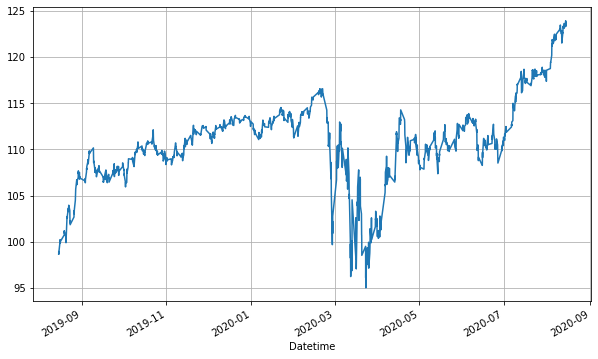

In [21]:
p = propuesta.plot(figsize=(10,6))
p.grid()

In [22]:
propuesta

Datetime
2019-08-15 09:30:00-04:00     98.652528
2019-08-15 10:30:00-04:00     98.944172
2019-08-15 11:30:00-04:00     98.786730
2019-08-15 12:30:00-04:00     98.711242
2019-08-15 13:30:00-04:00     98.777945
                                ...    
2020-08-14 11:30:00-04:00    123.546524
2020-08-14 12:30:00-04:00    123.619841
2020-08-14 13:30:00-04:00    123.734915
2020-08-14 14:30:00-04:00    123.331004
2020-08-14 15:30:00-04:00    123.506032
Length: 1765, dtype: float64

In [23]:
ponderaciones = cartera.MinCVaR.sort_values(axis=0,ascending=False)
ponderaciones.head(10)

ARCO    0.147227
WMT     0.147227
COST    0.147227
ABEV    0.137576
TGT     0.128251
PG      0.128251
NKE     0.119254
PEP     0.041878
MO      0.001472
KO      0.001472
Name: MinCVaR, dtype: float64